In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
import numpy as np
import matplotlib.pyplot as plt
from kan import *

from kan.utils import create_dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Регрессия**

In [3]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

## **Adam**

checkpoint directory created: ./model
saving model version 0.0


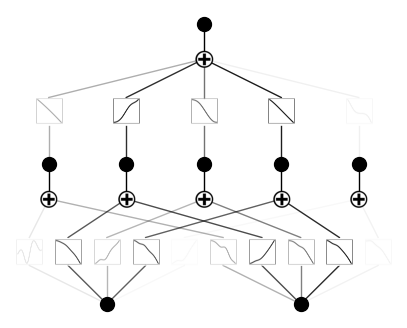

In [4]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [5]:
model.fit(dataset, opt="Adam", steps=400, lamb=0.);

| train_loss: 5.47e-02 | test_loss: 5.84e-02 | reg: 6.24e+01 | : 100%|█| 400/400 [00:06<00:00, 60.30


saving model version 0.1


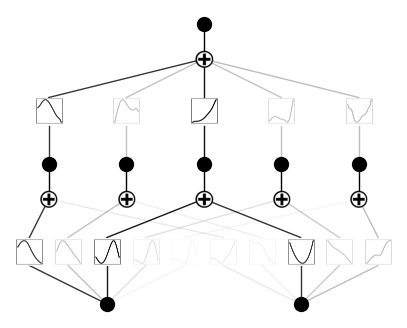

In [6]:
model.plot()

saving model version 0.2


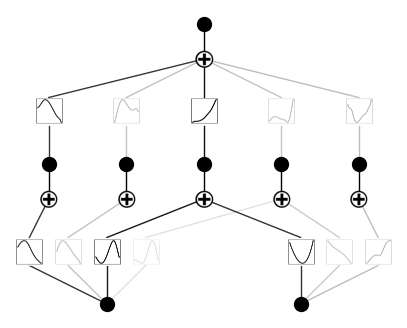

In [7]:
model = model.prune()
model.plot()

In [8]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [11]:
# dataset['train_input'].shape, dataset['train_label'].shape
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

batch_size = dataset['train_input'].shape[0]

for epoch in range(400):
        
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{400}], Train Loss: {train_loss.item():.4f}')

Epoch [20/400], Train Loss: 0.0636
Epoch [40/400], Train Loss: 0.0217
Epoch [60/400], Train Loss: 0.0136
Epoch [80/400], Train Loss: 0.0115
Epoch [100/400], Train Loss: 0.0104
Epoch [120/400], Train Loss: 0.0095
Epoch [140/400], Train Loss: 0.0088
Epoch [160/400], Train Loss: 0.0082
Epoch [180/400], Train Loss: 0.0077
Epoch [200/400], Train Loss: 0.0073
Epoch [220/400], Train Loss: 0.0069
Epoch [240/400], Train Loss: 0.0066
Epoch [260/400], Train Loss: 0.0063
Epoch [280/400], Train Loss: 0.0060
Epoch [300/400], Train Loss: 0.0057
Epoch [320/400], Train Loss: 0.0054
Epoch [340/400], Train Loss: 0.0051
Epoch [360/400], Train Loss: 0.0048
Epoch [380/400], Train Loss: 0.0042
Epoch [400/400], Train Loss: 0.0035


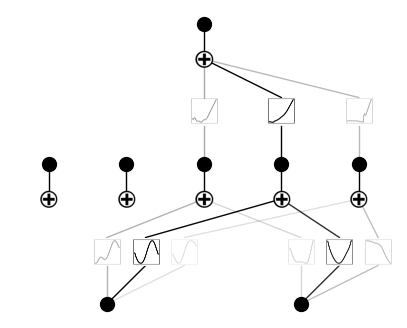

In [12]:
model.plot()

saving model version 0.1


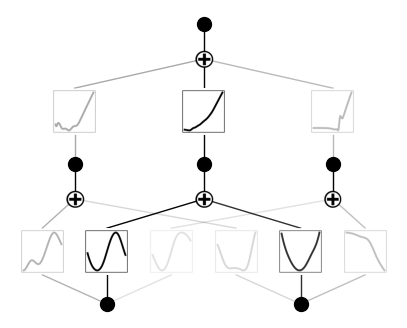

In [13]:
model = model.prune()
model.plot()

## **LBFGS**

checkpoint directory created: ./model
saving model version 0.0


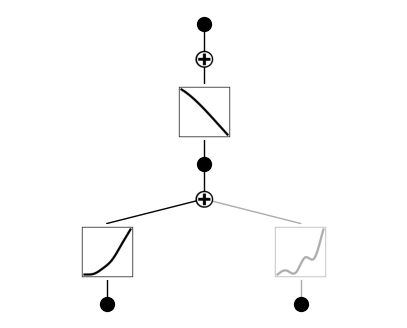

In [38]:
model = KAN(width=[2, 1, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [39]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.01);

| train_loss: 6.04e-01 | test_loss: 5.85e-01 | reg: 7.38e+00 | : 100%|█| 50/50 [00:14<00:00,  3.42it

saving model version 0.1


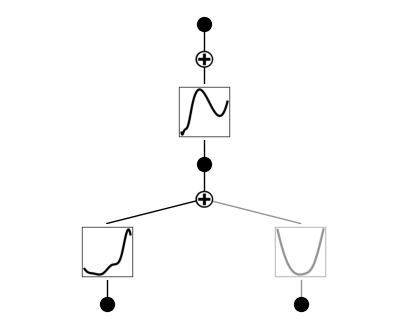

In [40]:
model.plot()

saving model version 0.2


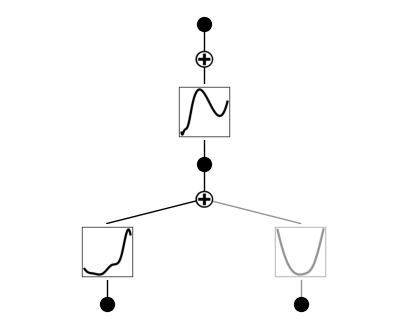

In [41]:
model = model.prune()
model.plot()

In [42]:
lib = ['1/x', 'x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.6905322670936584, c=1
fixing (0,1,0) with x^2, r2=0.9901619553565979, c=2
fixing (1,0,0) with x, r2=0.2882469594478607, c=1
saving model version 0.3


0.9296*x_1 + 0.0055*(0.0514 - 7.6575*x_2)**2 + 1.6967

checkpoint directory created: ./model
saving model version 0.0


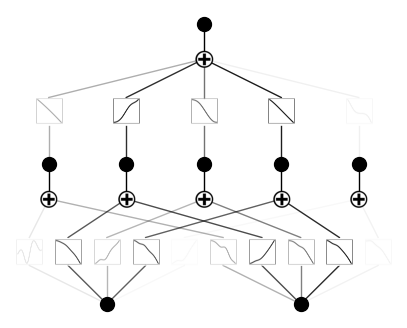

In [43]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [105]:
# dataset['train_input'].shape, dataset['train_label'].shape
optimizer = optim.LBFGS(params=model.parameters(), lr=1., history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
criterion = nn.MSELoss()

train_losses = []

batch_size = dataset['train_input'].shape[0]

old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(0.)

for epoch in range(50):
    
    if epoch == 49 and old_save_act:
        model.save_act = True
    
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    y_th=1000.
    
    def closure():
        reg_ = torch.tensor(10.)
        lamb = 0.
        
        optimizer.zero_grad()
        
        # pred = model(batch_x)
        pred = model.forward(batch_x, singularity_avoiding=False, y_th=y_th)
        
        loss = criterion(pred, batch_y)
        
        objective = loss + lamb * reg_
        # print(objective)
        objective.backward()
        return objective
    
    # Backward pass
    # optimizer.zero_grad()
    # loss.backward()
    optimizer.step(closure)
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{50}], Train Loss: {loss.item():.4f}')

Epoch [1/50], Train Loss: 0.1142
Epoch [2/50], Train Loss: 0.1142
Epoch [3/50], Train Loss: 0.1142
Epoch [4/50], Train Loss: 0.1142
Epoch [5/50], Train Loss: 0.1142
Epoch [6/50], Train Loss: 0.1142
Epoch [7/50], Train Loss: 0.1142
Epoch [8/50], Train Loss: 0.1142
Epoch [9/50], Train Loss: 0.1142
Epoch [10/50], Train Loss: 0.1142
Epoch [11/50], Train Loss: 0.1142
Epoch [12/50], Train Loss: 0.1142
Epoch [13/50], Train Loss: 0.1142
Epoch [14/50], Train Loss: 0.1142
Epoch [15/50], Train Loss: 0.1142
Epoch [16/50], Train Loss: 0.1142
Epoch [17/50], Train Loss: 0.1142
Epoch [18/50], Train Loss: 0.1142
Epoch [19/50], Train Loss: 0.1142
Epoch [20/50], Train Loss: 0.1142
Epoch [21/50], Train Loss: 0.1142
Epoch [22/50], Train Loss: 0.1142
Epoch [23/50], Train Loss: 0.1142
Epoch [24/50], Train Loss: 0.1142
Epoch [25/50], Train Loss: 0.1142
Epoch [26/50], Train Loss: 0.1142
Epoch [27/50], Train Loss: 0.1142
Epoch [28/50], Train Loss: 0.1142
Epoch [29/50], Train Loss: 0.1142
Epoch [30/50], Train Lo

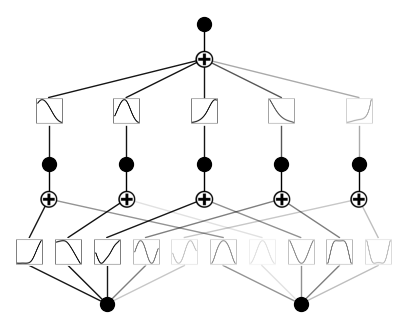

In [106]:
model.plot()

saving model version 0.1


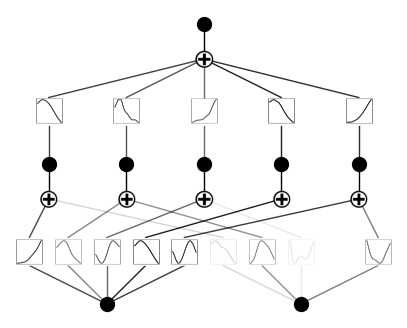

In [39]:
model = model.prune()
model.plot()

## **x^2**

In [101]:
f = lambda x: torch.log(torch.exp(torch.sin(x[:, [0]]) + x[:,[1]]**2))
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


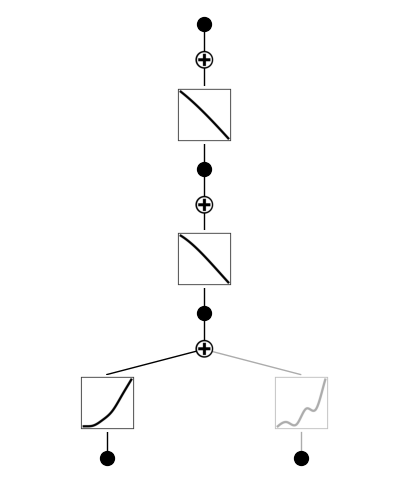

In [102]:
model = KAN(width=[2, 1, 1, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [103]:
model.fit(dataset, opt="Adam", steps=400, lamb=0.);

| train_loss: 3.03e-01 | test_loss: 3.01e-01 | reg: 3.40e+01 | : 100%|█| 400/400 [00:06<00:00, 60.46

saving model version 0.1


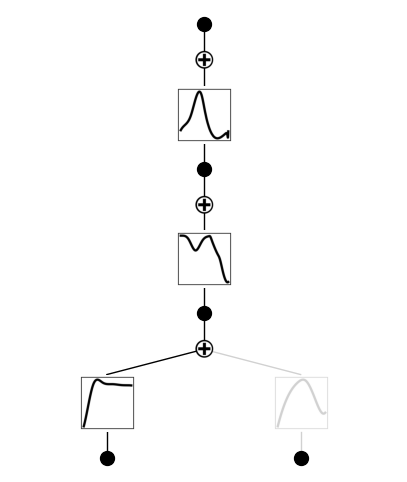

In [104]:
model.plot()

In [108]:
lib = ['1/x', 'x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.fix_symbolic(0,0,0,'exp')
model.fix_symbolic(0,1,0,'exp')
model.fix_symbolic(1,0,0,'sin')
model.fix_symbolic(2,0,0,'sin')
# model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

r2 is 0.9270208477973938
saving model version 0.8
r2 is 0.40528789162635803
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.9
r2 is 0.8330087065696716
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.10
r2 is 0.8933705687522888
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.11


0.7024*sin(3.601*sin(-10.1086 + 0.0006*exp(-5.3742*x_2) + 0.0094*exp(-5.8821*x_1)) - 5.6348) + 0.2138

## **[1 / x] + Adam**

In [208]:
# f = lambda x: 1 / x[:,[0]]
# dataset = create_dataset(f, n_var=1, device=device)
# dataset['train_input'].shape, dataset['train_label'].shape
end_range = 100.0
start_range = 1.0
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = x[:, 0] / x[:, 1]
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


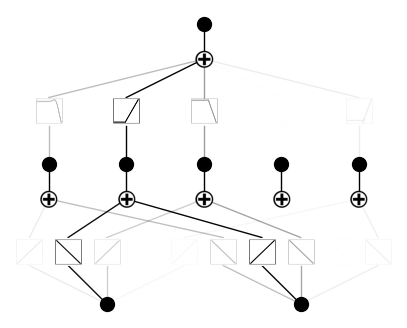

In [209]:
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [210]:
model.fit(dataset, opt="Adam", steps=600, lamb=0.);

| train_loss: 3.77e-01 | test_loss: 5.79e-01 | reg: 3.05e+01 | : 100%|█| 600/600 [00:07<00:00, 82.68


saving model version 0.1


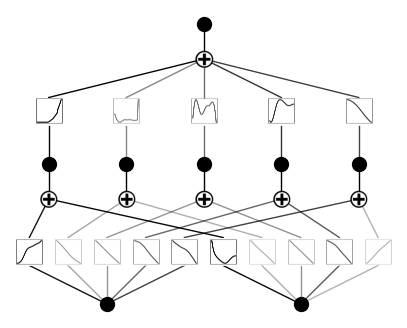

In [211]:
model.plot()

saving model version 0.2


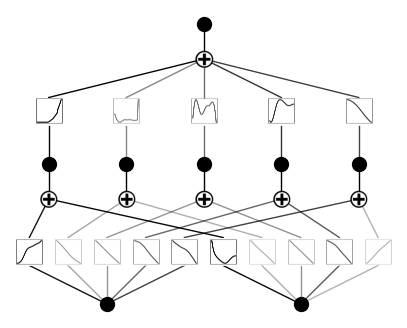

In [212]:
model = model.prune()
model.plot()

In [213]:
lib = ['1/x', 'x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9268248677253723, c=1
fixing (0,0,1) with x, r2=0.99324631690979, c=1
fixing (0,0,2) with x, r2=0.9997624158859253, c=1
fixing (0,0,3) with x, r2=0.980749785900116, c=1
fixing (0,0,4) with x, r2=0.9669991135597229, c=1
fixing (0,1,0) with x, r2=0.20341335237026215, c=1
fixing (0,1,1) with x, r2=0.9995275139808655, c=1
fixing (0,1,2) with x, r2=0.9999520182609558, c=1
fixing (0,1,3) with x, r2=0.9866761565208435, c=1
fixing (0,1,4) with x, r2=0.9974841475486755, c=1
fixing (1,0,0) with exp, r2=0.9825826287269592, c=2
fixing (1,1,0) with x, r2=0.05341304838657379, c=1
fixing (1,2,0) with x, r2=0.002895782934501767, c=1
fixing (1,3,0) with x, r2=0.2035161405801773, c=1
fixing (1,4,0) with x, r2=0.9872219562530518, c=1
saving model version 0.3


In [199]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.033*x_1 + 0.0114*x_2 - 0.6861*exp(0.0104*x_1) - 1.6589 + 81.7803/(-0.1008*x_1 + 1.1727*x_2 + 2.7063)

In [27]:
end_range = 5.0
start_range = 0.5
num_samples = 1000
x = (end_range - start_range) * torch.rand(num_samples + 200, 2) + start_range
y = x[:, 1] + 1 / x[:, 0]
dataset = {
    'train_input': x[:1000],
    'train_label': y[:1000].unsqueeze(dim=1),
    
    'test_input': x[-200:],
    'test_label': y[-200:].unsqueeze(dim=1),
}
dataset['train_input'] = dataset['train_input'].to(device)
dataset['train_label'] = dataset['train_label'].to(device)
dataset['test_input'] = dataset['test_input'].to(device)
dataset['test_label'] = dataset['test_label'].to(device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


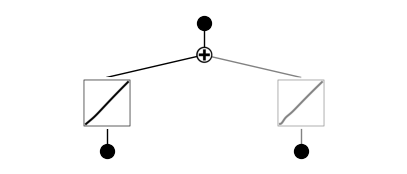

In [28]:
model = KAN(width=[2, 1], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [29]:
# dataset['train_input'].shape, dataset['train_label'].shape
optimizer = optim.Adam(model.parameters(), lr=1.0)
criterion = nn.MSELoss()

batch_size = dataset['train_input'].shape[0]

for epoch in range(600):
    # Случайный батч для обучения
    train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
    
    model.update_grid(dataset['train_input'][train_id])
    
    batch_x = dataset['train_input'][train_id]
    batch_y = dataset['train_label'][train_id]
    
    # Forward pass
    outputs = model(batch_x)
    
    train_loss = criterion(outputs, batch_y)
    
    loss = train_loss + 0.1
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{600}], Train Loss: {train_loss.item():.4f}')

Epoch [20/600], Train Loss: 3.4742
Epoch [40/600], Train Loss: 0.2141
Epoch [60/600], Train Loss: 0.0134
Epoch [80/600], Train Loss: 0.0069
Epoch [100/600], Train Loss: 0.0004
Epoch [120/600], Train Loss: 0.0003
Epoch [140/600], Train Loss: 0.0002
Epoch [160/600], Train Loss: 0.0001
Epoch [180/600], Train Loss: 0.0001
Epoch [200/600], Train Loss: 0.0001
Epoch [220/600], Train Loss: 0.0001
Epoch [240/600], Train Loss: 0.0001
Epoch [260/600], Train Loss: 0.0000
Epoch [280/600], Train Loss: 0.0000
Epoch [300/600], Train Loss: 0.0000
Epoch [320/600], Train Loss: 0.0000
Epoch [340/600], Train Loss: 0.0000
Epoch [360/600], Train Loss: 0.0000
Epoch [380/600], Train Loss: 0.0000
Epoch [400/600], Train Loss: 0.0000
Epoch [420/600], Train Loss: 0.0000
Epoch [440/600], Train Loss: 0.0000
Epoch [460/600], Train Loss: 0.0000
Epoch [480/600], Train Loss: 0.0000
Epoch [500/600], Train Loss: 0.0000
Epoch [520/600], Train Loss: 0.0000
Epoch [540/600], Train Loss: 0.0000
Epoch [560/600], Train Loss: 0.0

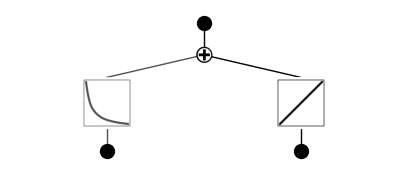

In [30]:
model.plot()

saving model version 0.1
fixing (0,0,0) with 1/x, r2=0.9998103380203247, c=2
fixing (0,1,0) with x, r2=1.000000238418579, c=1
saving model version 0.2


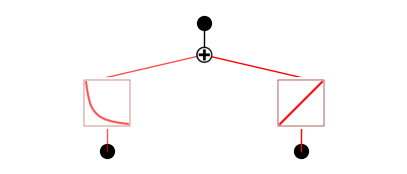

In [31]:
model = model.prune()
lib = ['1/x', 'x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
model.plot()

In [18]:
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

0.0114 + 0.4625*exp(-0.1178*x_1)

## ****

## ****

In [ ]:
# 1. Создание составной модели
class KANWithFC(nn.Module):
    def __init__(self, input_dim=2, hidden_dim1=2, hidden_dim2=3, output_dim=1):
        """
        Составная модель с KAN слоями и полносвязным слоем
        Args:
            input_dim: размер входа
            hidden_dim1: ширина первого KAN слоя
            hidden_dim2: ширина второго KAN слоя
            output_dim: размер выхода
        """
        super(KANWithFC, self).__init__()
        
        # Первый KAN слой: вход 2 -> выход 2
        self.kan1 = KAN(width=[input_dim, hidden_dim1], grid=5, k=3, seed=42)
        
        # Второй KAN слой: вход 2 -> выход 3
        self.kan2 = KAN(width=[hidden_dim1, hidden_dim2], grid=5, k=3, seed=42)
        
        # Полносвязный слой с ReLU: вход 3 -> выход 1
        self.fc = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        
        # Отключаем символические вычисления для ускорения
        self.kan1.symbolic_enabled = False
        self.kan2.symbolic_enabled = False
        
    def forward(self, x):
        # Проход через первый KAN
        x = self.kan1(x)
        
        # Проход через второй KAN
        x = self.kan2(x)
        
        # Полносвязный слой с ReLU
        x = self.fc(x)
        x = self.relu(x)
        
        return x
    
    def fit_combined(self, train_input, train_label, test_input, test_label, 
                     epochs=100, lr=0.001, batch_size=32):
        """
        Обучение составной модели
        """
        # Оптимизатор для всей модели
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        train_losses = []
        test_losses = []
        
        for epoch in range(epochs):
            # Случайный батч для обучения
            indices = torch.randperm(train_input.shape[0])[:batch_size]
            batch_x = train_input[indices]
            batch_y = train_label[indices]
            
            # Forward pass
            outputs = self(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Вычисление ошибки на тестовом наборе
            with torch.no_grad():
                test_outputs = self(test_input)
                test_loss = criterion(test_outputs, test_label)
                
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
        return train_losses, test_losses
